# Feature Importance

## Outline

Feature importance is a technique that allows us to identify the most contributing features in a given dataset by some scoring method. The score can be defined by any model evaluated on the dataset. However, users must be careful while selecting the evaluation critieria and model as the importance of a particular input feature is dependent on these two choices.

We score each feature by scrambling its values and fitting the model. The relative change in performance of the model fit on the scrambled feature dataset versus the original feature dataset tells us the importance. 

### Load Dependencies

In [1]:
import numpy as np
import pandas as pd
import math

import torch
from torch.autograd import Variable, grad
from torch.autograd.functional import jacobian
import torch.nn.functional as F
import torch.utils.data as Data
from torch import nn, optim

from sklearn.metrics import r2_score, mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

from L96_model import (
    L96,
    L96_eq1_xdot,
    integrate_L96_2t,
    EulerFwd,
    RK2,
    RK4,
)

%matplotlib inline

In [2]:
np.random.seed(14)  # For reproducibility
torch.manual_seed(14)  # For reproducibility

### Generate L96 data

In [3]:
time_steps = 20000
Forcing, dt, T = 18, 0.01, 0.01 * time_steps

# Create a "synthetic world" with K=8 and J=32
K = 8
J = 32
W = L96(K, J, F=Forcing)
# Get training data for the neural network.

# - Run the true state and output subgrid tendencies (the effect of Y on X is xy_true):
X_true, _, _, xy_true = W.run(dt, T, store=True, return_coupling=True)

### Helper functions

In [4]:
def plot_feature_importance(result):
    fig = plt.figure()
    ax = fig.add_axes([0, 0, 1, 1])
    ax.set_xlabel("Shift in score")
    ax.set_ylabel("Column")
    ax.set_title("Permutation Feature Importance")

    predictors = result[:, 0]
    scores = result[:, 1]
    y_pos = range(len(predictors))

    ax.barh(y_pos, scores)
    plt.yticks(y_pos, predictors)
    plt.show()

## Theory

The two-scale Lorenz '96 system is periodic in nature. Hence for a given output feature, the importance of the input feature should gradually increase and then decrease in a circular manner. To confirm this, we test the importance of the first output feature with respect to individual input features. 

<center>
  <img
    src="https://www.researchgate.net/publication/319201436/figure/fig1/AS:869115023589376@1584224577926/Visualisation-of-a-two-scale-Lorenz-96-system-with-J-8-and-K-6-Global-scale-values.png"
    width=400
  />
</center>

<span> <center> *Fig. 1: Visualisation of a two-scale Lorenz '96 system with J = 8 and K = 6. Global-scale variables ($X_k$) are updated based on neighbouring variables and on the local-scale variables ($Y_{j,k}$) associated with the corresponding global-scale variable. Local-scale variabless are updated based on neighbouring variables and the associated global-scale variable. The neighbourhood topology of both local and global-scale variables is circular. Image from [Exploiting the chaotic behaviour of atmospheric models with reconfigurable architectures - Scientific Figure on ResearchGate.](https://www.researchgate.net/figure/Visualisation-of-a-two-scale-Lorenz-96-system-with-J-8-and-K-6-Global-scale-values_fig1_319201436)* </center> </span>

In [5]:
feature_index = 0

In [6]:
y = xy_true[:, feature_index]

## Feature importance using Linear Regression

In [7]:
model = LinearRegression()
model.fit(X_true, y)

LinearRegression()

In [8]:
baseline = r2_score(model.predict(X_true), y)
results = []
for column in range(X_true.shape[1]):
    # Create a copy of X_test
    X_true_copy = X_true.copy()

    # Scramble the values of the given predictor
    np.random.shuffle(X_true_copy[:, column])

    # Calculate the new R2
    score = r2_score(model.predict(X_true_copy), y)

    # Append the increase in R2 to the list of results
    results.append([column, abs(score - baseline)])
results = np.array(results)

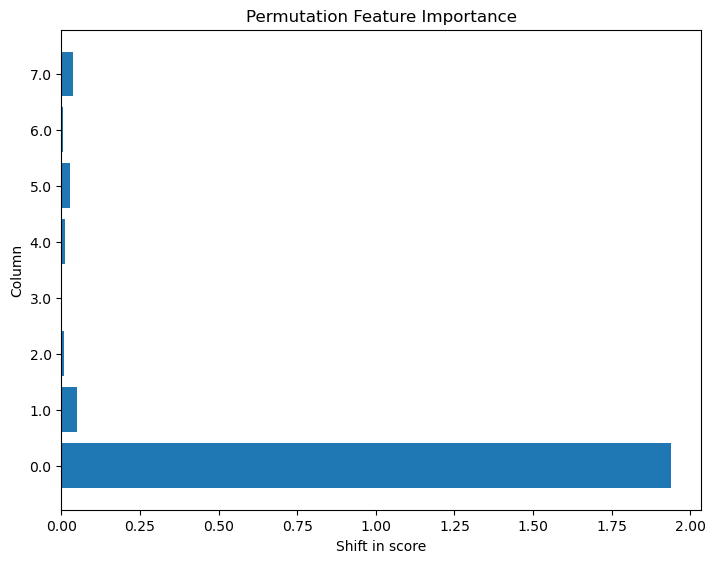

In [9]:
plot_feature_importance(results)

## Feature importance using Artificial Neural Network

In [10]:
# Specify a path
PATH = "networks/network_3_layers_100_epoches.pth"
# Load
weights = torch.load(PATH)
weights.keys()

odict_keys(['linear1.weight', 'linear1.bias', 'linear2.weight', 'linear2.bias', 'linear3.weight', 'linear3.bias'])

In [11]:
class Net_ANN(nn.Module):
    def __init__(self):
        super(Net_ANN, self).__init__()
        self.linear1 = nn.Linear(8, 16)  # 8 inputs, 16 neurons for first hidden layer
        self.linear2 = nn.Linear(16, 16)  # 16 neurons for second hidden layer
        self.linear3 = nn.Linear(16, 8)  # 8 outputs

    def forward(self, x):
        x = x.to(self.linear1.weight.dtype)
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        x = self.linear3(x)
        return x

In [12]:
model = Net_ANN()
model.load_state_dict(weights)
model.eval()

Net_ANN(
  (linear1): Linear(in_features=8, out_features=16, bias=True)
  (linear2): Linear(in_features=16, out_features=16, bias=True)
  (linear3): Linear(in_features=16, out_features=8, bias=True)
)

In [13]:
baseline = r2_score(model(torch.tensor(X_true)).detach().numpy()[:, feature_index], y)
results = []
for column in range(X_true.shape[1]):
    # Create a copy of X_test
    X_true_copy = X_true.copy()

    # Scramble the values of the given predictor
    np.random.shuffle(X_true_copy[:, column])

    # Calculate the new R2
    score = r2_score(
        model(torch.tensor(X_true_copy)).detach().numpy()[:, feature_index], y
    )

    # Append the increase in R2 to the list of results
    results.append([column, abs(score - baseline)])

# Put the results into a pandas dataframe and rank the predictors by score
results = np.array(results)

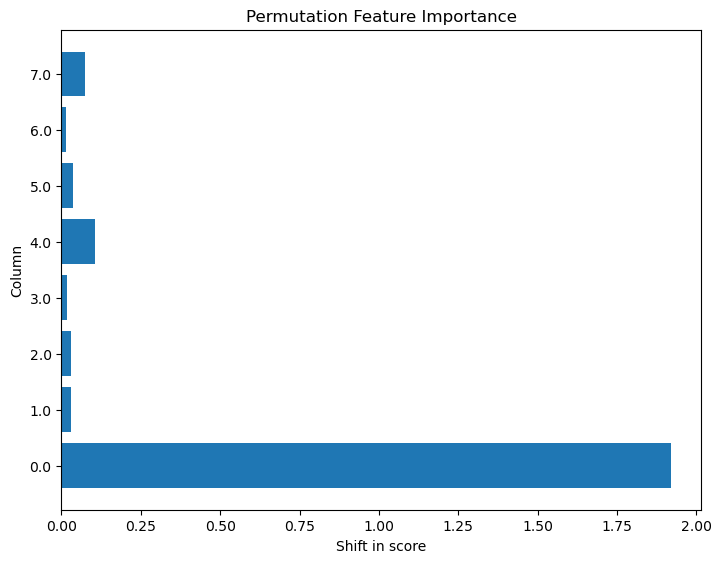

In [14]:
plot_feature_importance(results)

## Observation and Discussion

In this notebook, we introduce the idea of permutation feature importance. We test the importance of individual input features for the first output feature. We observe:
- The first input feature has the highest impact on the first output feature regardless of the model used to evaluate the data.
- The last input feature has observable impact on the first output feature showcasing the periodic nature of the two-scale Lorenz '96 system.